<a href="https://colab.research.google.com/github/Zarif123/SSLM-Project/blob/main/confusion_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
%%capture
!pip install transformers
!pip install python-chess

In [17]:
from datetime import datetime

from google.colab import drive
drive.mount('/content/gdrive')
folder = "/content/gdrive/MyDrive/Statistical_LM_Group_Folder"

csv_file = "chess_data_with_buckets.csv"
csv_path = f"{folder}/{csv_file}"


now = datetime.now()
dt_string = now.strftime("%m_%d_%Y_%H_%M")

model_file = "classifier_model.pth"
datetime = dt_string
model_path = f"{folder}/{datetime}_{model_file}"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, get_linear_schedule_with_warmup
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

###Parameters

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

params = {
    "batch_size": 4,
    "epochs": 5,
    "learning_rate": 0.00003,
    "warmup_steps": 0.01,
    "epsilon": 1e-8,
    "accum_iter": 8,
    "num_classes": 6,
    "dropout": 0.5
}

class Params:
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

params = Params(**params)

### Classify Model

In [20]:
class BertClassifier(nn.Module):
  def __init__(self, dropout=params.dropout, num_classes=params.num_classes):
    super(BertClassifier, self).__init__()

    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Linear(768, num_classes)
    # self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_id, mask):
    _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
    dropout_output = self.dropout(pooled_output)
    linear_output = self.linear(dropout_output)
    final_layer = self.softmax(linear_output)

    return final_layer

### Dataset Class

In [21]:
class ChessDataset(torch.utils.data.Dataset):
  def __init__(self, moves, labels):
      tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
      self.labels = torch.Tensor(labels.values)
      self.moves = [tokenizer(move, 
                              padding='max_length', max_length = 256, truncation=True,
                              return_tensors="pt") for move in moves]

  def __len__(self):
      return len(self.labels)

  def __getitem__(self, idx):
      return self.moves[idx], self.labels[idx]

### Test Function

In [39]:
def test(model, test_dataloader):
  total_acc_test = 0
  count = 0
  truth = []
  pred = []
  with torch.no_grad():
    for test_input, test_label in test_dataloader:
      test_label = test_label.to(device)
      mask = test_input['attention_mask'].to(device)
      input_id = test_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)

      acc = (output.argmax(dim=1) == test_label).sum().item()
      total_acc_test += acc
      count += 1
      truth.append(test_label.item())
      pred.append(output.argmax(dim=1).item())
      # print(f"Test Accuracy: {total_acc_test / len(test_dataloader): .3f}")
  return truth, pred

### Loading Data

In [23]:
%%capture
chess_data = pd.read_csv(csv_path)
X = chess_data["Moves"]
y = chess_data["Bucket"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, shuffle=True) # Splits into train/test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, shuffle=True) # Splits train into train/val

test_data = ChessDataset(X_test, y_test)

In [24]:
test_dataloader = torch.utils.data.DataLoader(test_data)

### Run Testing

In [40]:
test_model_name = "06_01_2023_20_17_classifier_model.pth"
test_model_path = f"{folder}/{test_model_name}"

test_model = BertClassifier()
test_model = test_model.to(device)
test_model.load_state_dict(torch.load(test_model_path))
truth, pred = test(test_model, test_dataloader)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


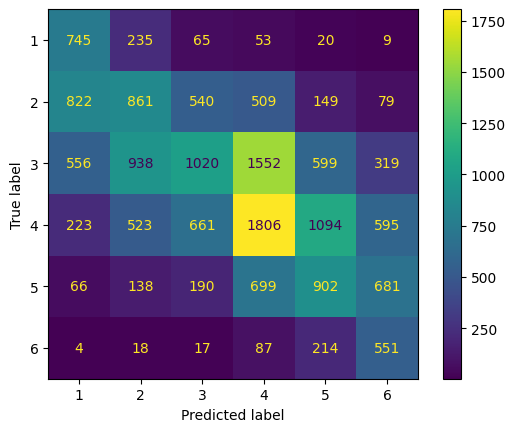

In [42]:
confusion_mat = confusion_matrix(truth, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=["1", "2", "3", "4", "5", "6"])
disp.plot()
plt.show()